<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/Hierarchical_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You might need the data from here: http://www.stat.columbia.edu/~gelman/arm/examples/election88/

In [1]:
!pip install pyreadstat pyro-ppl

     |████████████████████████████████| 2.4 MB 15.2 MB/s 
     |████████████████████████████████| 718 kB 33.8 MB/s 
     |████████████████████████████████| 750.6 MB 9.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [11]:
import pyreadstat
import time 
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal


from torch import nn
from pyro.nn import PyroModule
from pyro.infer import MCMC, NUTS, Predictive

import sklearn.model_selection

polls_df, meta = pyreadstat.read_dta('polls.dta')
polls_df = polls_df.dropna()
presvote_df, _ = pyreadstat.read_dta('presvote.dta')

In [4]:
# Apologies, for this, this is how they do it in the R code as well. 
# The list has length 51 since they add D.C as its own state.
state_to_region_mapping = torch.tensor([3,4,4,3,4,4,1,1,5,3,3,4,4,2,2,2,2,3,3,1,1,1,2,2,3,2,4,2,4,1,1,4,1,3,2,2,3,4,1,1,3,2,3,3,4,1,3,4,1,2,4])
state_to_region_mapping = state_to_region_mapping.repeat(len(polls_df), 1)
indices = torch.tensor(polls_df['state'].values, dtype=torch.int64) - 1
polls_df['region'] = state_to_region_mapping.gather(1, indices.view(-1, 1))

polls_df['black_female'] = polls_df['black']*polls_df['female']
polls_df['age_edu'] = polls_df['age']*polls_df['edu']

presvote_df = presvote_df.rename(columns={'stnum2': 'state', 'g76_84pr':'previous_vote'})

polls_df = polls_df.join(other=presvote_df.set_index('state'), on='state')

polls_df['age'] = polls_df['age'] - 1
polls_df['edu'] = polls_df['edu'] - 1
polls_df['region_full'] = polls_df['region'] - 1
polls_df['state'] = polls_df['state'] - 1


@All: Need to check that the preprocessing is correct; In my opinion the model assumes / requires that all variables are transformed such that they lie in {0, 1, ..., n_distinct_elemts}

In [5]:
age = torch.tensor(polls_df[["age"]].values, dtype=torch.int64)
edu = torch.tensor(polls_df[["edu"]].values, dtype=torch.int64)
age_edu = torch.tensor(polls_df[["age_edu"]].values, dtype=torch.int64)
state = torch.tensor(polls_df[["state"]].values, dtype=torch.int64)
region_full = torch.tensor(polls_df[["region"]].values, dtype=torch.int64)
female = torch.tensor(polls_df[["black"]].values, dtype=torch.int64)
black = torch.tensor(polls_df[["female"]].values, dtype=torch.int64)
v_prev_full = torch.tensor(polls_df[['previous_vote']].values, dtype = torch.float64)
y = torch.tensor(polls_df[["bush"]].values,  dtype=torch.float64)

n_age_categories = max(age) + 1
n_edu_categories = max(edu) + 1
n_age_edu_categories = max(age_edu) + 1
n_state_categories = max(state) + 1
n_region_full_categories = max(region_full) + 1

In [6]:
def get_features_and_targets(dataframe):
  feature_names = ["female", "black", "previous_vote", "age", "edu", "age_edu", "region", "state"]
  features = []
  for feature in feature_names:
    if feature == "previous_vote":
      dtype = torch.float64
    else:
      dtype = torch.int64
    
    features.append(torch.tensor(dataframe[[feature]].values, dtype=dtype))
  targets = torch.tensor(dataframe[["bush"]].values,  dtype=torch.float64)
  return features, targets

In [7]:
train_df, test_df = sklearn.model_selection.train_test_split(polls_df, train_size=10000)

train_features, train_targets = get_features_and_targets(train_df)
test_features, test_targets = get_features_and_targets(test_df)

In [8]:
def model(female, black, v_prev_full, age, edu, age_edu, region_full, state, y):
      #Unifrom hyper-priors constraint between 0 and 100 for variances
      sigma_a = pyro.sample('sigma_a', dist.Uniform(0., 100.))
      sigma_b = pyro.sample('sigma_b', dist.Uniform(0., 100.))
      sigma_c = pyro.sample('sigma_c', dist.Uniform(0., 100.))
      sigma_d = pyro.sample('sigma_d', dist.Uniform(0., 100.))
      sigma_e = pyro.sample('sigma_e', dist.Uniform(0., 100.))
      
      #priors for hierarchical log reg
      beta = pyro.sample('beta', dist.Normal(0., 100.).expand([5]).to_event(1))
      a = pyro.sample("a", dist.Normal(0., sigma_a).expand(n_age_categories).to_event(1))
      b = pyro.sample("b", dist.Normal(0., sigma_b).expand(n_edu_categories).to_event(1))
      c = pyro.sample("c", dist.Normal(0., sigma_c).expand(n_age_edu_categories).to_event(1))
      d = pyro.sample("d", dist.Normal(0., sigma_d).expand(n_state_categories).to_event(1))
      e = pyro.sample("e", dist.Normal(0., sigma_e).expand(n_region_full_categories).to_event(1))

      #logits
      logits = beta[0] \
            +beta[1]*black \
            +beta[2]*female \
            +beta[4]*female*black \
            +beta[3]+v_prev_full \
            +a[age] \
            +b[edu] \
            +c[age_edu] \
            +d[state] \
            +e[region_full]

      with pyro.plate("data", len(logits)):
        obs = pyro.sample("obs", dist.Bernoulli(logits = logits).to_event(1), obs=y)

In [47]:
torch.manual_seed(0)

guide = AutoDiagonalNormal(model)
adaprop = pyro.optim.AdagradRMSProp(dict())
svi = SVI(model, guide, adaprop, loss=Trace_ELBO())

pyro.clear_param_store()
output_advi = pd.DataFrame(columns = ["t", "num_samples", "test_accuracy", "model"])

step_ids = []
average_log_predictives = []
train_time = 0

eval_steps = np.concatenate((np.arange(0, 100, 10),
                             np.arange(100, 2000, 100)))

for j in range(2000):
    # calculate the loss and take a gradient step
    t0 = time.time()
    loss = svi.step(*train_features, train_targets)
    t1 = time.time()
    train_time += (t1-t0)

    if j in eval_steps:
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)
      train_predictions = predictive_svi(*train_features, None)
      test_predictions = predictive_svi(*test_features, None)
      train_obs = train_predictions['obs'].numpy()
      test_obs = test_predictions['obs'].numpy()
      average_train_log_accuracy = torch.mean(torch.log(torch.sum(torch.tensor(train_obs) ==  torch.tile(train_targets, (num_samples, 1, 1)), axis=1)/len(train_targets)))
      average_test_log_accuracy = torch.mean(torch.log(torch.sum(torch.tensor(test_obs) ==  torch.tile(test_targets, (num_samples, 1, 1)), axis=1)/len(test_targets)))

      step_ids.append(j)
      average_log_predictives.append(average_test_log_accuracy)

      output_iter = {"run_id":"n/a",
                    "t":train_time,
                    "num_samples":"n/a", 
                    "test_accuracy":average_test_log_accuracy.detach().numpy(),
                    "model":"advi"}

      output_advi = output_advi.append(output_iter, ignore_index = True)
      print("[iteration %04d] loss: %.4f" % (j + 1, average_test_log_accuracy))

    

[iteration 0001] loss: -0.8463
[iteration 0011] loss: -0.7497
[iteration 0021] loss: -0.7113
[iteration 0031] loss: -0.6758
[iteration 0041] loss: -0.6701
[iteration 0051] loss: -0.6660
[iteration 0061] loss: -0.6599
[iteration 0071] loss: -0.6525
[iteration 0081] loss: -0.6442
[iteration 0091] loss: -0.6334
[iteration 0101] loss: -0.6376
[iteration 0201] loss: -0.6161
[iteration 0301] loss: -0.6196
[iteration 0401] loss: -0.6118
[iteration 0501] loss: -0.6169
[iteration 0601] loss: -0.6074
[iteration 0701] loss: -0.6164
[iteration 0801] loss: -0.6156
[iteration 0901] loss: -0.6130
[iteration 1001] loss: -0.6152
[iteration 1101] loss: -0.6249
[iteration 1201] loss: -0.6049
[iteration 1301] loss: -0.6111
[iteration 1401] loss: -0.6188
[iteration 1501] loss: -0.6222
[iteration 1601] loss: -0.6082
[iteration 1701] loss: -0.6262
[iteration 1801] loss: -0.6134
[iteration 1901] loss: -0.6136


In [51]:
# Run MCMC using Stan kernel
torch.manual_seed(1)
pyro.clear_param_store()

output_mcmc = pd.DataFrame(columns = ["run_id", "t", "num_samples", "test_accuracy", "model"])

sample_size_l = np.arange(10, 100, 10)
sample_size_s = np.arange(2, 10, 5)
sample_size = np.concatenate((sample_size_s, sample_size_l))

for size in sample_size: 
  
    num_samples = size
    num_warmups = size
    
    print('Num samples: {}'.format(num_samples))

    nuts_kernel = NUTS(model,
                       max_tree_depth = 4)

    mcmc = MCMC(
            nuts_kernel,
            num_samples=num_samples,
            warmup_steps=num_warmups,
            disable_progbar=False,
            num_chains = 1
    ) 

    start = time.time()
    mcmc.run(*train_features, train_targets)
    end = time.time()

    samples = mcmc.get_samples()
    mcmc_predictive = Predictive(model, samples)(*test_features, None)
    test_obs = mcmc_predictive['obs'].numpy()
    average_test_log_accuracy = torch.mean(torch.log(torch.sum(torch.tensor(test_obs) ==  torch.tile(test_targets, (num_samples, 1, 1)), axis=1)/len(test_targets)))
    
    output_iter = {"run_id":"n/a",
                  "t":end-start,
                  "num_samples":num_samples, 
                  "test_accuracy":average_test_log_accuracy.detach().numpy(),
                  "model":"nuts"}

    output_mcmc = output_mcmc.append(output_iter, ignore_index = True)
    print(average_test_log_accuracy)

Num samples: 2


Sample: 100%|██████████| 4/4 [00:00, 20.81it/s, step size=7.30e-02, acc. prob=0.000]


tensor(-0.6169)
Num samples: 7


Sample: 100%|██████████| 14/14 [00:01, 10.01it/s, step size=1.55e-02, acc. prob=0.905]


tensor(-0.6053)
Num samples: 10


Sample: 100%|██████████| 20/20 [00:02,  9.17it/s, step size=1.12e-02, acc. prob=0.934]


tensor(-0.6118)
Num samples: 20


Sample: 100%|██████████| 40/40 [00:04,  8.87it/s, step size=8.05e-02, acc. prob=0.836]


tensor(-0.6176)
Num samples: 30


Sample: 100%|██████████| 60/60 [00:07,  7.83it/s, step size=1.18e-01, acc. prob=0.740]


tensor(-0.6103)
Num samples: 40


Sample: 100%|██████████| 80/80 [00:10,  7.85it/s, step size=8.40e-02, acc. prob=0.935]


tensor(-0.6123)
Num samples: 50


Sample: 100%|██████████| 100/100 [00:12,  7.80it/s, step size=6.27e-02, acc. prob=0.959]


tensor(-0.6199)
Num samples: 60


Sample: 100%|██████████| 120/120 [00:14,  8.21it/s, step size=6.89e-02, acc. prob=0.670]


tensor(-0.6151)
Num samples: 70


Sample: 100%|██████████| 140/140 [00:17,  8.14it/s, step size=6.46e-02, acc. prob=0.892]


tensor(-0.6155)
Num samples: 80


Sample: 100%|██████████| 160/160 [00:19,  8.12it/s, step size=1.20e-01, acc. prob=0.858]


tensor(-0.6172)
Num samples: 90


Sample: 100%|██████████| 180/180 [00:23,  7.79it/s, step size=3.68e-02, acc. prob=0.964]


tensor(-0.6172)


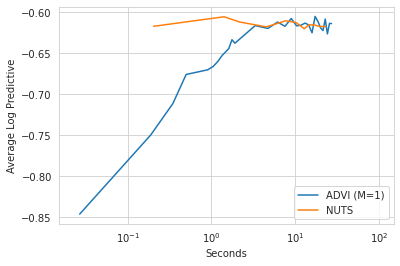

In [54]:
# Generate plot (Figure 4 in original paper)

output = output_advi.append(output_mcmc, ignore_index=True)
output = output.loc[output['t'] < 100]
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style("whitegrid")
results = sns.lineplot(data = output, x = 't', y = 'test_accuracy', hue = 'model')
results.set(xscale='log', 
            xlim = (0.015, 150), 
            xlabel = 'Seconds',
            ylabel = 'Average Log Predictive')
plt.legend(labels=["ADVI (M=1)","NUTS"])